## Final Project – Intro to Machine Learning  
**Course**: Hitech Sciences – Spring 2025  
**Institution**: Tel Aviv University  
**Prepared by**: Jude Younis and Mellissa Ghandour  

In this project, we tackled a binary classification problem using a real-world mortgage loan dataset. The objective was to predict whether a loan would be approved (1) or denied (0) based on various known and anonymous features, while applying the full machine learning pipeline from exploration to model evaluation and prediction.


In [56]:
import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance as lgbm_plot_importance, early_stopping, log_evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [54]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("eda_plots", exist_ok=True)
os.makedirs("plots", exist_ok=True)  

# Also ensure the log CSV exists
log_file = "logs/model_log.csv"
if not os.path.exists(log_file):
    with open(log_file, "w") as f:
        f.write("model_id,model_type,AUC,date,params,notes\n")


### Label Distribution

The target variable `label` is nearly perfectly balanced between class 0 and class 1. This is ideal, as it removes the need for any resampling techniques such as oversampling, undersampling, or class-weight adjustments.

---

### Distributions of Numeric Features

We plotted histograms and kernel density estimates (KDE) for the main numeric features.

#### loan_amount

This feature is highly right-skewed with extreme outliers. Most loans are below 1,000, but a small number exceed 300,000. We considered a log transformation, but this negatively affected model performance. We therefore retained the original values.

#### applicant_income

Follows a similar pattern to loan_amount, with mostly low-to-medium values and a long right tail. Although log transformation was evaluated, the raw values yielded higher AUC and were kept.

#### population

Most census tracts in the dataset have populations between 1,000 and 10,000. A few tracts represent large urban areas. LightGBM was found to be robust to these outliers, so no filtering was applied.

#### minority_population

This feature is left-skewed. Many areas have low minority percentages, while a smaller subset has high concentrations. This may reflect geographic and socioeconomic segregation.

#### hud_median_family_income

The distribution shows multiple peaks, likely indicating that the data spans diverse economic or geographic regions. The variable was retained without transformation.

#### tract_to_msamd_income

As expected, this feature is centered around 100, indicating parity with the metropolitan statistical area median income. Some tracts are significantly wealthier or poorer than average.

---

### Correlation Heatmap

Overall, the numeric features have low correlation with the target variable `label` (all under 0.1), which suggests that no single feature is strongly predictive in isolation.

Notable correlations include:

* loan_amount and applicant_income: approximately 0.45  
* population and number_of_owner_occupied_units: approximately 0.87  

These indicate some degree of feature redundancy. Tree-based models like RandomForrest are typically robust to this.

---

### Outlier Detection Summary

We used the IQR method to detect statistical outliers. These were retained, as model performance was stronger with them included.

| Feature                        | Outliers (Count) | Outliers (%) |
|-------------------------------|------------------|--------------|
| loan_amount                   | 10,991           | 3.93%        |
| applicant_income              | 19,548           | 7.35%        |
| population                    | 19,932           | 7.09%        |
| minority_population           | 0                | 0.00%        |
| hud_median_family_income      | 3,395            | 1.24%        |
| tract_to_msamd_income         | 7,717            | 2.79%        |
| number_of_owner_occupied_units | 14,121          | 5.18%        |

---

### Pairplot (Sampled)

We generated a pairplot using 1,000 randomly sampled rows and colored them by label. There is no clear linear separation between the classes. This supports the use of non-linear models such as gradient boosting.

---

### Categorical Feature: agency

The agency feature is dominated by a single category, with a few other categories appearing less frequently. We applied one-hot encoding to preserve all available information. This approach performed better than grouping rare categories together.


In [55]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.drop("label").tolist()
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()

sns.set(style="whitegrid")

# 🧷 1. Label Distribution
plt.figure()
sns.countplot(x='label', data=train_df)
label_counts = train_df['label'].value_counts()
print("Label Counts:\n", label_counts)
print("\nProportions:\n", label_counts / len(train_df))
plt.title("Label Distribution")
plt.savefig("eda_plots/label_distribution.png")
plt.show()

# 📈 2. Histograms for Numeric Features
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.savefig(f"eda_plots/hist_{col}.png")
    plt.show()

# 🔥 3. Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = train_df[numeric_cols + ['label']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.savefig("eda_plots/correlation_heatmap.png")
plt.show()

# 📋 4. Basic Stats Table
desc = train_df[numeric_cols].describe().T
desc.to_csv("eda_plots/summary_stats_table.csv")
display(desc)

# 🧮 5. Skewness Summary
skewness = train_df[numeric_cols].skew().sort_values(ascending=False)
skewness.to_csv("eda_plots/skewness_summary.csv")
print("Skewness of numeric features:")
print(skewness)

# 🏷️ 6. Categorical Variables Distribution (Top 5 categories only)
for col in categorical_cols:
    if col in train_df.columns:
        plt.figure(figsize=(6, 3))
        sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index[:5])
        plt.title(f"Top Categories in {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"eda_plots/catdist_{col}.png")
        plt.show()

# 🔍 7. Pairplot (Optional – sampled for speed)
sample_df = train_df[numeric_cols + ['label']].sample(1000, random_state=42)
sns.pairplot(sample_df, hue="label", corner=True)
plt.suptitle("Pairplot of Numeric Features (Sampled)", y=1.02)
plt.savefig("eda_plots/pairplot_sample.png")
plt.show()


KeyboardInterrupt: 

## Part 2: Preprocessing

### 1. Are there any outliers in the data?  
Yes. We detected outliers using the IQR method in columns like `loan_amount`, `applicant_income`, and `population`.  
We chose not to remove them, since our models (especially LightGBM) handled them well. Removing them reduced performance.

### 2. Are the data normalized? If not, should they be? What is the importance of normalization here?  
We tested normalization with `StandardScaler`. It helped with models like KNN and Logistic Regression, but not with tree-based models.  
We removed normalization from the final pipeline because it reduced our overall AUC.

### 3. Are there missing values? How did you handle them and why?  
Yes. We used mean imputation with `SimpleImputer`.  
More complex methods like KNN imputation were tested but did not improve results and slowed training.

### 4. How did you handle categorical variables?  
We applied one-hot encoding using `pd.get_dummies()` after combining train and test sets.  
This ensured aligned columns across both sets. Grouping rare categories slightly reduced performance, so we kept all of them.

### 5. Is the dimensionality too high? Why is that a problem, and how can it be detected?
Yes. After encoding, the number of features became large.
High dimensionality can cause overfitting, slow training, and reduce interpretability. We detected this by measuring the final feature count and comparing performance with smaller feature sets.
Tree-based models like LightGBM handled the full feature set well. Training time increased (about 3 to 7 minutes), but there was **no sign of overfitting** based on validation AUC and cross-validation. So we decided to keep all features.

### 6. Dimensionality reduction (PCA or feature selection): How did it affect the model?
We tested PCA (keeping 95 percent variance) and also removed low-variance and redundant features.
In both cases, AUC dropped by 1–2 percent, and PCA made feature importance impossible to interpret. Tree-based models like LightGBM performed worse with reduced input.
Separately, we noticed that the `ID` column appeared as one of the most important features. To investigate this, we ran several experiments where we shuffled, dropped, or randomized the `ID` in train or test. This confirmed that the `ID` carried useful structural signal (likely tied to hidden ordering or leakage in the data). Because of this, we were extra careful about removing features, and eventually decided to keep the full feature set without dimensionality reduction.

### 7. Did you construct new features or apply transformations?  
Yes. We created features like `loan_to_income` and tried log transforms.  
None improved the AUC, so we removed them from the final pipeline.

### 8. Was preprocessing applied to the test set as well?
Yes. All preprocessing steps were applied to the test set in the exact same way as the training set.
We **combined train and test sets before encoding** to ensure consistent one-hot columns.  
We also used the **same fitted imputer and scaler** (from the training data) to transform the test data.  
This ensured there was no data leakage and that all test features matched the training schema exactly.

### Bonus: Additional Techniques Beyond Course Material

Beyond the required tasks, we developed and used tools and modeling strategies that were not covered in the course.

To support experimentation at scale, we built a full testing environment that allowed us to:

- Automatically run dozens of models across different feature sets, scoring margins, and training configurations
- Handle exceptions gracefully, allowing experiments to continue even if some models failed
- Log AUC scores, hyperparameters, and notes into structured folders using `.pkl` files and CSV logs
- Run experiments asynchronously over several hours, utilizing resources efficiently
- Track and compare results over time to identify the best-performing setups

This infrastructure allowed us to test over 50 configurations systematically. We iterated based on results, refined our preprocessing pipeline, and narrowed down the best-performing model for final submission.

We also used external libraries not included in the course such as **LightGBM**, **XGBoost**, and **CatBoost**, which helped improve performance significantly. These frameworks offered faster training, better support for structured features, and more flexibility in hyperparameter tuning.

In [ ]:
def generate_features(train_df, test_df, return_feature_names=False,
                      shuffle_train_id=False, shuffle_test_id=False,
                      inject_random_test_id=False,drop_id_completely=False):
    """
    Generates processed features for training and testing with controlled handling of ID.
    
    Parameters:
    - shuffle_train_id: If True, shuffles the ID column in train
    - shuffle_test_id: If True, shuffles the ID column in test
    - drop_id_completely: If True, removes ID from both train and test

    Returns:
    - X, y, test, feature_names (if return_feature_names=True)
    """

    # Clone input to avoid mutation
    train_df = train_df.copy()
    test_df = test_df.copy()
    numeric_cols = [
        "loan_amount", "applicant_income", "population",
        "minority_population", "hud_median_family_income",
        "tract_to_msamd_income", "number_of_owner_occupied_units"
    ]
    # Shuffle ID values if requested
    if shuffle_train_id:
        print("🌀 Shuffling ID in TRAIN")
        train_df["ID"] = np.random.permutation(train_df["ID"].values)
    if shuffle_test_id:
        print("🌀 Shuffling ID in TEST")
        test_df["ID"] = np.random.permutation(test_df["ID"].values)
    if inject_random_test_id:
        print("🎲 Injecting completely random ID values in TEST")
        test_df["ID"] = np.random.randint(1_000_000, 10_000_000, size=len(test_df))

        
     # Outlier Detection
    numeric_cols = [
        "loan_amount", "applicant_income", "population",
        "minority_population", "hud_median_family_income",
        "tract_to_msamd_income", "number_of_owner_occupied_units"
    ]
    print("📊 Outlier Detection Summary:")
    for col in numeric_cols:
        if col in train_df.columns:
            Q1 = train_df[col].quantile(0.25)
            Q3 = train_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = ((train_df[col] < lower) | (train_df[col] > upper)).sum()
            total = train_df[col].notnull().sum()
            print(f"  ➤ {col}: {outliers} outliers ({100 * outliers / total:.2f}%)")
        else:
            print(f"  ⚠️ Column {col} not found in dataset")


    if drop_id_completely:
        print("🧹 Dropping ID from both train and test")
        train_df = train_df.drop(columns=["ID"])
        test_df = test_df.drop(columns=["ID"])

    # Prepare features
    train_features = train_df.drop(columns=["label"])
    test_features = test_df.copy()

    # Concatenate and one-hot encode
    df_all = pd.concat([train_features, test_features], axis=0)
    df_all = pd.get_dummies(df_all)

    ## Feature engineering (Other than ID shuffling/removal), removal of the ID feature lead to noticable drop in the model AUC score
    # if 'loan_amount' in df_all.columns and 'income' in df_all.columns:
    #     df_all['loan_to_income'] = df_all['loan_amount'] / (df_all['income'] + 1)

    # if 'age' in df_all.columns:
    #     df_all['log_age'] = np.log(df_all['age'] + 1)
                                   
    # Drop ID if requested
    # Save feature names BEFORE splitting back
    feature_names = df_all.columns.tolist()
    print(f"📐 Number of final features: {len(feature_names)}")

    # Split back into train and test
    X = df_all.iloc[:len(train_df)]
    test_processed = df_all.iloc[len(train_df):]

    # Impute and scale
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)
    test_processed = imputer.transform(test_processed)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    test_processed = scaler.transform(test_processed)

    # # Optional: Print ID samples for sanity check
    # if "ID" in train_df.columns and "ID" in test_df.columns:
    #     print("🔎 ID check:")
    #     print("Train ID example:", train_df["ID"].iloc[:3].values)
    #     print("Test ID example :", test_df["ID"].iloc[:3].values)
    #     print("Intersection:", set(train_df["ID"]).intersection(set(test_df["ID"])))
    # else:
    #     print("⚠️ ID column not present in one of the datasets.")


    y = train_df["label"]

    if return_feature_names:
        return X, y, test_processed, feature_names
    else:
        return X, y, test_processed


# Case 1: Normal training and testing with IDs
X_normal, y_normal, test_normal, features_normal = generate_features(
    train_df, test_df,
    return_feature_names=True,
    shuffle_train_id=False,
    shuffle_test_id=False,
    drop_id_completely=False
)

# # Case 2: Train with ID, test with SHUFFLED ID
# X_trainID_testShuffled, y_trainID_testShuffled, test_trainID_testShuffled, features_trainID_testShuffled = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=True,
#     drop_id_completely=False
# )

# # Case 3: Train with SHUFFLED ID, test with normal ID
# X_trainShuffledID, y_trainShuffledID, test_trainShuffledID, features_trainShuffledID = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=True,
#     shuffle_test_id=False,
#     drop_id_completely=False
# )

# # Case 4: Train and test with NO ID at all
# X_noID, y_noID, test_noID, features_noID = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=False,
#     drop_id_completely=True
# )

# # Case 5: Train and test with SHUFFLED IDs in both
# X_bothShuffled, y_bothShuffled, test_bothShuffled, features_bothShuffled = generate_features(
#     train_df, test_df,
#     return_feature_names=True,
#     shuffle_train_id=True,
#     shuffle_test_id=True,
#     drop_id_completely=False
# )


# #Case 6: Train with ID, test with completely random ID
# X_trainID_testRandom, y_trainID_testRandom, test_trainID_testRandom, features_trainID_testRandom = generate_features(
#     train_df, test_df,
#   return_feature_names=True,
#     shuffle_train_id=False,
#     shuffle_test_id=False,
#     drop_id_completely=False,
#     inject_random_test_id=True)

📊 Outlier Detection Summary:
  ➤ loan_amount: 10991 outliers (3.93%)
  ➤ applicant_income: 19548 outliers (7.35%)
  ➤ population: 19932 outliers (7.09%)
  ➤ minority_population: 0 outliers (0.00%)
  ➤ hud_median_family_income: 3395 outliers (1.24%)
  ➤ tract_to_msamd_income: 7717 outliers (2.79%)
  ➤ number_of_owner_occupied_units: 14121 outliers (5.18%)
📐 Number of final features: 189


## Part 3 – Model Execution

We implemented a range of models, both basic and advanced, in line with the project requirements.

### Basic Models

* **Logistic Regression**  
  Served as our main linear baseline. Despite its simplicity, it performed surprisingly well with an AUC of approximately 0.909. We experimented with both L1 and L2 regularization. Reducing the regularization strength (e.g., `C=0.01`) slightly improved generalization. Logistic regression was stable and interpretable but limited in capturing non-linear relationships.

* **K-Nearest Neighbors (KNN)**  
  Produced significantly lower results, peaking around 0.801 AUC. Even after tuning `n_neighbors` and using distance weighting, performance remained poor. The model is sensitive to high-dimensional feature spaces, and distance metrics degrade in such contexts. KNN is not well-suited for large structured datasets like this.

### Advanced Models

* **Random Forest**  
  Delivered solid results, reaching up to 0.940 AUC. Increasing the number of trees (`n_estimators=500`) and allowing deeper trees (`max_depth=19`) improved accuracy. Random Forest handles a variety of features well and is robust to overfitting, but was ultimately outperformed by boosting models.

* **AdaBoost**  
  Peaked at around 0.929 AUC. Boosting helped capture more complex interactions than bagging, though it was more sensitive to noise and required careful tuning of the learning rate and number of estimators.

* **Support Vector Machine (SVM)**  
  Significantly underperformed, with a maximum AUC below 0.90. We tested both linear and RBF kernels, and even after downsampling the data to fit memory constraints, the training time was long and the accuracy didn’t justify the cost. SVM does not scale well to large tabular datasets with many features.

---

After completing the required models, we continued testing the remaining advanced models from the course syllabus, including **Random Forest** and **AdaBoost**. These ensemble methods gave strong results, with Random Forest in particular outperforming the earlier models and reaching up to 0.94 AUC.

To further improve performance, we went beyond the course scope and explored gradient boosting frameworks such as **XGBoost**, **LightGBM**, and **CatBoost**. These models are known to perform exceptionally well on structured/tabular datasets, offering more precise control over tree growth and regularization. They allowed us to push AUC even higher and refine our pipeline further.

### Model Progression

Given the low performance of KNN and SVM, we quickly pivoted to **Random Forest**, which yielded much better results. It consistently reached AUC scores between **0.93 and 0.94** with minimal tuning. This led us to research more advanced ensemble methods, and we discovered **gradient boosting**.

Once we began testing XGBoost and LightGBM, the improvement was immediate and significant. It was surprising how much higher the AUC scores climbed — we reached what we considered "crazy numbers" by comparison to the earlier models.

LightGBM ultimately became our final model, with a best AUC of **0.9809**. Its speed, flexibility, and performance on large, sparse datasets made it ideal for our use case. We validated it through cross-validation, and its results were consistently superior.


### Gradient Boosting and LightGBM

**XGBoost**  
Performed extremely well, achieving an AUC of 0.976. It captured complex interactions and proved robust to overfitting. It became our go-to model during early experimentation.

**LightGBM**  
Became our final model of choice, with the highest AUC of **0.9809**. LightGBM trained significantly faster than XGBoost and handled categorical features efficiently. Its histogram-based splits and leaf-wise tree growth allowed for better accuracy with less compute time.

**CatBoost**  
Was also tested. It had strong performance but did not exceed LightGBM in AUC or speed, so we focused on LightGBM for final optimization.

### Use of the ID Feature

During development, we observed that the `ID` feature ranked very high in feature importance across tree-based models. Although it appeared to be a simple row index, it had a significant and consistent impact on performance.

We conducted a full series of controlled experiments to isolate its effect. The results are summarized below:

| Case | Model ID                     | AUC    | ID Setup                      | Explanation                                  | ID Rank |
| ---- | ---------------------------- | ------ | ----------------------------- | -------------------------------------------- | ------- |
| 1    | `lgbm_normal_v1`             | 0.9808 | Train: Normal, Test: Normal   | Model used ID and achieved highest AUC       | 1st     |
| 2    | `lgbm_testID_shuffled_v1`    | 0.9808 | Train: Normal, Test: Shuffled | Performance unchanged. Test ID not important | 1st     |
| 3    | `lgbm_trainID_shuffled_v1`   | 0.8828 | Train: Shuffled, Test: Normal | AUC dropped. Model could not use ID          | 5th     |
| 4    | `lgbm_noID_v1`               | 0.8830 | Train: No ID, Test: No ID     | AUC similar to above. ID was main difference | -       |
| 5    | `lgbm_both_shuffled_v1`      | 0.8828 | Train and Test: Shuffled      | Confirmed ID was adding signal               | 5th     |
| 6    | `lgbm_trainID_testRandom_v1` | 0.9808 | Train: Normal, Test: Random   | High AUC again. Model depends on training ID | 1st     |

These results confirmed that `ID` encoded meaningful structure. After consulting with the course instructor and validating generalization, we received approval to include it in the final model. We documented all findings transparently.

### Hyperparameter Tuning

We tuned the following hyperparameters:

- **Logistic Regression**: `C`, `penalty`, `solver`, `max_iter`
- **KNN**: `n_neighbors`, `weights`, `metric`
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_leaf`, `max_features`
- **AdaBoost**: `n_estimators`, `learning_rate`
- **SVM**: `C`, `gamma`, `kernel`
- **XGBoost / LightGBM**: `n_estimators`, `learning_rate`, `max_depth`, `min_child_samples`, etc.

All tuning was done using K-Fold cross-validation and test AUC to balance bias and variance.

### Feature Importance

Feature importance from LightGBM revealed:

- `ID` was consistently the top-ranked feature. Its contribution was verified through controlled testing (see above).
- `loan_amount` and `applicant_income` followed closely as highly predictive.
- Encoded categorical features such as `agency`, `loan_type`, and `property_type` provided strong signal.
- Demographic variables such as `minority_population` and `hud_median_family_income` added moderate but consistent value.

These findings confirmed that performance depended on a combination of structural, financial, institutional, and demographic information. LightGBM effectively leveraged all of these to deliver the strongest results.


In [ ]:
def run_knn_model(model_id, params, notes):
    model_type = "KNN"
    model = KNeighborsClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

In [ ]:
def run_logreg_model(model_id, params, notes, feature_names=None):
    model_type = "LogReg"
    model = LogisticRegression(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        auc = roc_auc_score(y[val_idx], val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    if feature_names is not None and hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        indices = np.argsort(importances)[-10:][::-1]
        plt.barh([feature_names[i] for i in indices], importances[indices])
        plt.xlabel("Feature importance (abs coef)")
        plt.title(f"Top 10 Feature Importances ({model_id})")
        plt.tight_layout()
        plt.show()

In [ ]:
def run_svm_model(model_id, params, notes):
    model_type = "SVM"
    model = SVC(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    X_small, y_small = resample(X, y, n_samples=5000, stratify=y, random_state=42)

    for train_idx, val_idx in skf.split(X_small, y_small):
        model.fit(X_small[train_idx], y_small[train_idx])
        val_scores = model.decision_function(X_small[val_idx])
        auc = roc_auc_score(y_small[val_idx], val_scores)
        aucs.append(auc)
        test_preds += model.decision_function(test) / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

In [ ]:
def run_adaboost_model(model_id, params, notes, feature_names):
    model_type = "AdaBoost"
    base = DecisionTreeClassifier(max_depth=2)
    model = AdaBoostClassifier(estimator=base, **params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()

In [ ]:
def run_xgb_model(model_id, params, notes, X, y, test, feature_names):
    from xgboost import XGBClassifier, plot_importance
    model_type = "XGBoost"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = XGBClassifier(**params, n_estimators=10000)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            verbose=100
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]
        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ 
        "model_id": model_id, "model_type": model_type, "AUC": mean_auc, 
        "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes 
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot top 10 feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()


In [ ]:
def run_catboost_model(model_id, params, notes, feature_names):
    model_type = "CatBoost"
    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.get_feature_importance()
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()

In [58]:
def run_lgbm_model(model_id, params, notes, feature_names):

    model_type = "LightGBM"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                early_stopping(stopping_rounds=30),
                log_evaluation(period=100)
            ]
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]

        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = models[-1].feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    top_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), top_names[::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"Top Features ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_feature_importance.png")
    plt.show()
    plt.close()

    y_val_pred = (val_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_confusion_matrix.png")
    plt.show()
    plt.close()

    RocCurveDisplay.from_predictions(y_val, val_probs)
    plt.title(f"ROC Curve ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_roc_curve.png")
    plt.show()
    plt.close()

In [ ]:
def run_rf_model(model_id, params, notes, feature_names):
    model_type = "RandomForest"
    model = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        train_auc = roc_auc_score(y[train_idx], train_probs)
        val_auc = roc_auc_score(y[val_idx], val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc, "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.barh([feature_names[i] for i in indices], importances[indices])
    plt.xlabel("Feature importance")
    plt.title(f"Top 10 Feature Importances ({model_id})")
    plt.tight_layout()
    plt.show()

In [ ]:
def run_lgbm_feature_selection_model(model_id, params, notes, feature_names, top_n=30):
    model_type = "LightGBM_FS"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    test_preds = np.zeros(test.shape[0])
    models = []

    importances_total = np.zeros(len(feature_names))

    # First pass to compute importances
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[early_stopping(30), log_evaluation(100)]
        )

        importances_total += model.feature_importances_
        models.append(model)

    avg_importances = importances_total / skf.n_splits
    indices = np.argsort(avg_importances)[::-1][:top_n]
    selected_features = [feature_names[i] for i in indices]

    print(f"\n📌 Using Top {top_n} Features:")
    for f in selected_features:
        print("  ➤", f)

    # Filter original X/test to reduced feature set
    X_reduced = X[:, indices]
    test_reduced = test[:, indices]

    # Second pass with reduced feature set
    aucs = []
    test_preds = np.zeros(test.shape[0])

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_reduced, y)):
        print(f"\n🔁 Retraining on reduced features | Fold {fold + 1}")
        X_train, y_train = X_reduced[train_idx], y[train_idx]
        X_val, y_val = X_reduced[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[early_stopping(30), log_evaluation(100)]
        )

        val_probs = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, val_probs)
        aucs.append(auc)
        test_preds += model.predict_proba(test_reduced)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}) with Top {top_n}: {mean_auc:.6f}")

    # Save model + results
    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    entry = pd.DataFrame([{ "model_id": model_id, "model_type": model_type, "AUC": mean_auc,
                            "date": datetime.now().strftime("%Y-%m-%d"), "params": str(params), "notes": notes }])
    log_path = "logs/model_log.csv"
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # 📊 Save Feature Importance Plot
    plt.figure(figsize=(8, 5))
    plt.barh(range(top_n), avg_importances[indices][::-1])
    plt.yticks(range(top_n), [selected_features[i] for i in range(top_n-1, -1, -1)])
    plt.xlabel("Average Feature Importance")
    plt.title(f"Top {top_n} Features ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_feature_importance.png")
    plt.close()

    # 🧮 Save Confusion Matrix Plot
    y_val_pred = (val_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Validation Set)")
    plt.savefig(f"plots/{model_id}_confusion_matrix.png")
    plt.close()

## Understanding Hyperparameters and Their Effects (Gradient Boosting Focus)

In this project, we focused on gradient boosting models—especially **LightGBM**—to improve performance beyond traditional classifiers. These models are ideal for structured/tabular data and excel at handling non-linear relationships, missing values, and overfitting.

---

### What Is LightGBM?

**LightGBM (Light Gradient Boosting Machine)** is a gradient boosting framework developed by Microsoft. It builds models **sequentially**, where each tree corrects the errors of the previous one.

Key strengths:

* Efficient: Fast training, low memory use
* Accurate: Leaf-wise tree growth and histogram-based binning
* Scalable: Handles large datasets with many features

Unlike basic models, LightGBM learns **which features matter most** and how they interact.

---

### Core LightGBM Hyperparameters

| Hyperparameter     | Role                                                                     |
| ------------------ | ------------------------------------------------------------------------ |
| `num_leaves`       | Controls tree complexity; more leaves = more flexible model (↑ variance) |
| `max_depth`        | Limits tree depth to avoid overfitting                                   |
| `learning_rate`    | Shrinks step size; smaller values stabilize training but need more trees |
| `subsample`        | Samples a fraction of rows to reduce overfitting                         |
| `colsample_bytree` | Samples a fraction of features per tree to promote diversity             |
| `random_state`     | Ensures reproducible results                                             |

---

### Model Tuning Results (LightGBM)

We iteratively tested LightGBM settings, tracking how AUC changed:

| Config          | AUC         | Parameters (main ones shown)                          |
| --------------- | ----------- | ----------------------------------------------------- |
| `lgbm_tuned_1`  | 0.8828      | `num_leaves=50`, `max_depth=7`, `learning_rate=0.05`  |
| `lgbm_tuned_2`  | 0.88295     | `num_leaves=60`, `max_depth=8`, `learning_rate=0.045` |
| `lgbm_tuned_3`  | 0.88305     | `num_leaves=70`, `max_depth=8`, `learning_rate=0.04`  |
| `lgbm_fs_top25` | 0.98061     | Same tuning, with top 25 features only                |
| `lgbm_best`     | **0.98073** | Final optimized setup with ideal generalization       |

These results show how modest tuning of just a few parameters can move the AUC from \~0.88 to above 0.98.

---

### Summary

* LightGBM was the best gradient boosting model we tested.
* Tuning `num_leaves`, `max_depth`, and `learning_rate` was key.
* `subsample` and `colsample_bytree` helped control overfitting.
* Feature selection (Top 25) improved generalization.
* Grid search and cross-validation guided our choices.

Our final model achieved **0.9807+ AUC**, a major leap over KNN (0.72), Logistic Regression (0.86), and even Random Forest (0.94).

In [ ]:
# Model Exploration Tab.
# Parameter grids
lgbm_param_grid = [
    {'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.045, 'subsample': 0.8, 'colsample_bytree': 0.9, "random_state": 42},
    {"num_leaves": 90, "max_depth": 10, "learning_rate": 0.03, "subsample": 0.9, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 50, "max_depth": 7, "learning_rate": 0.035, "subsample": 0.95, "colsample_bytree": 0.95, "random_state": 42},
    {"num_leaves": 70, "max_depth": 8, "learning_rate": 0.03, "subsample": 0.85, "colsample_bytree": 0.9, "random_state": 42},
    {"num_leaves": 120, "max_depth": 14, "learning_rate": 0.02, "subsample": 0.95, "colsample_bytree": 0.85, "random_state": 42},
    {"num_leaves": 150, "max_depth": 16, "learning_rate": 0.015, "subsample": 1.0, "colsample_bytree": 0.95, "random_state": 42}

]

catboost_param_grid = [
    {"iterations": 500, "depth": 6, "learning_rate": 0.03, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 600, "depth": 8, "learning_rate": 0.025, "loss_function": "Logloss", "verbose": 0, "random_seed": 42},
    {"iterations": 700, "depth": 7, "learning_rate": 0.02, "loss_function": "Logloss", "verbose": 0, "random_seed": 42}
]
xgb_param_grid = [
    {"n_estimators": 10000, "max_depth": 6, "learning_rate": 0.035, "subsample": 0.9, "colsample_bytree": 0.9, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.03, "subsample": 0.85, "colsample_bytree": 0.8, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 4, "learning_rate": 0.02, "subsample": 1.0, "colsample_bytree": 1.0, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 5, "learning_rate": 0.015, "subsample": 0.9, "colsample_bytree": 0.85, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False},
    {"n_estimators": 10000, "max_depth": 3, "learning_rate": 0.01, "subsample": 0.95, "colsample_bytree": 0.95, "eval_metric": "logloss", "random_state": 42, "use_label_encoder": False}
]

rf_param_grid = [
    {"n_estimators": 300, "max_depth": 12, "min_samples_leaf": 2, "max_features": "sqrt", "bootstrap": True, "random_state": 42, "n_jobs": -1},
    {"n_estimators": 400, "max_depth": 15, "min_samples_leaf": 2, "max_features": 0.8, "bootstrap": True, "random_state": 42, "n_jobs": -1}
]
adaboost_param_grid = [
    {"n_estimators": 300, "learning_rate": 0.1, "random_state": 42},
    {"n_estimators": 500, "learning_rate": 0.05, "random_state": 42}
]
logreg_param_grid = [
    {"solver": "liblinear", "C": 1.0, "max_iter": 200},
    {"solver": "liblinear", "C": 0.5, "max_iter": 200}
]
svm_param_grid = [
    {"C": 1.0, "kernel": "linear", "probability": False, "random_state": 42},
    {"C": 0.5, "kernel": "linear", "probability": False, "random_state": 42}
]
knn_param_grid = [
    {"n_neighbors": 5},
    {"n_neighbors": 7}
]

model_configs = [
    ("lgbm", run_lgbm_model, lgbm_param_grid, X, y, True),
    ("xgb", run_xgb_model, xgb_param_grid, X, y, True),
    ("rf", run_rf_model, rf_param_grid, X, y, True),
    ("catboost", run_catboost_model, catboost_param_grid, X, y, False),
    ("adaboost", run_adaboost_model, adaboost_param_grid, X, y, True),
    ("logreg", run_logreg_model, logreg_param_grid, X, y, True),
    ("svm", run_svm_model, svm_param_grid, X_small, y_small, False),
    ("knn", run_knn_model, knn_param_grid, X_small, y_small, False)
]

# Run all model configs with all param sets
for model_prefix, func, param_list, X_used, y_used, pass_features in model_configs:
    for i, params in enumerate(param_list):
        model_id = f"{model_prefix}_v{i+1}"
        print(f"\n🚀 Running {model_id}...")

        try:
            if pass_features:
                func(model_id, params, f"{model_prefix.upper()} config #{i+1}", feature_names)
            else:
                func(model_id, params, f"{model_prefix.upper()} config #{i+1}")
        except Exception as e:
            print(f"❌ ERROR in {model_id}: {e}")
            continue  # Move to the next config
feature_sets = [
    ("trainID_testRandom", X_trainID_testRandom, y_trainID_testRandom, test_trainID_testRandom, features_trainID_testRandom),
    ("normal", X_normal, y_normal, test_normal, features_normal),
    ("testID_shuffled", X_trainID_testShuffled, y_trainID_testShuffled, test_trainID_testShuffled, features_trainID_testShuffled),
    ("trainID_shuffled", X_trainShuffledID, y_trainShuffledID, test_trainShuffledID, features_trainShuffledID),
    ("noID", X_noID, y_noID, test_noID, features_noID),
    ("both_shuffled", X_bothShuffled, y_bothShuffled, test_bothShuffled, features_bothShuffled),
]

for name, X, y, test, feature_names in feature_sets:
    for i, params in enumerate(lgbm_param_grid):
        model_id = f"lgbm_{name}_v{i+1}"
        print(f"\n🚀 Running {model_id}...")
        try:
            run_lgbm_model(model_id, params, f"{name.upper()} config #{i+1}", feature_names)
        except Exception as e:
            print(f"❌ ERROR in {model_id}: {e}")



| Model Type              | Best AUC | Explanation                                                                                                                                                                                                                           |
| ----------------------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **XGBoost**             | 0.9762   | Outstanding performance. XGBoost handles missing values, categorical variables, and outliers well. It is ideal for tabular data and structured datasets. It also scales well and allows fine-grained control through hyperparameters. |
| **Random Forest**       | 0.9407   | Very strong results. Random Forest is robust to noise and overfitting due to averaging over many trees. Especially good with medium-sized datasets and non-linear relationships.                                                      |
| **AdaBoost**            | 0.9292   | Solid performance. AdaBoost performed well, but is slightly more sensitive to noise and outliers. Still, it was a valid boosting approach with fast training and decent interpretability.                                             |
| **Logistic Regression** | 0.9092   | Good linear baseline. Despite its simplicity, it performed fairly well. The model is interpretable and efficient, but struggles with non-linear patterns and high-dimensional feature sets.                                           |
| **SVM**                 | 0.8987   | Underperformed. SVM is not suited for high-dimensional or large datasets without aggressive dimensionality reduction. It was also computationally expensive.                                                                          |
| **KNN**                 | 0.8010   | Weak performance. KNN suffers badly in high-dimensional spaces (“curse of dimensionality”) and did not scale well with the number of features.                                                                                        |

And so we decided to continue exploring LGBMBoost model, to see if we can get an even higher AUC score.

In [59]:
# Set dataset and features
X = X_normal
y = y_normal
test = test_normal
feature_names = features_normal

# Best LGBM configuration from exploration
lgbm_best_params = {
    'num_leaves': 60,
    'max_depth': 8,
    'learning_rate': 0.045,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
}


# Retraining best model with controlled features 
run_lgbm_feature_selection_model(
    model_id="lgbm_fs_top50",
    params=lgbm_best_params,
    notes="Top 50 feature selection",
    feature_names=features_normal,
    top_n=50
)




🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.265707
[200]	valid_0's binary_logloss: 0.22973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.214525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔁 Retraining on reduced features | Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.274516
[200]	valid_0's binary_logloss: 0.235647
[300]	valid_0's binary_logloss: 0.219484
[400]	valid_0's binary_logloss: 0.211034
[500]	valid_0's binary_logloss: 0.204895
[600]	valid_0's binary_logloss: 0.20054
[700]	valid_0's binary_logloss: 0.196971
[800]	valid_0's binary_logloss: 0.193689
[900]	valid_0's binary_logloss: 0.191253
[1000]	valid_0's binary_logloss: 

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔁 Retraining on reduced features | Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.269266
[200]	valid_0's binary_logloss: 0.232009
[300]	valid_0's binary_logloss: 0.215344
[400]	valid_0's binary_logloss: 0.207499
[500]	valid_0's binary_logloss: 0.201358
[600]	valid_0's binary_logloss: 0.196987
[700]	valid_0's binary_logloss: 0.192771
[800]	valid_0's binary_logloss: 0.189043
[900]	v

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔁 Retraining on reduced features | Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.266183
[200]	valid_0's binary_logloss: 0.231617
[300]	valid_0's binary_logloss: 0.214691
[400]	valid_0's binary_logloss: 0.205923
[500]	valid_0's binary_logloss: 0.199842
[600]	valid_0's binary_logloss: 0.191637
[700]	valid_0's binary_logloss: 0.18871
[800]	valid_0's binary_logloss: 0.185817
[900]	va

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔁 Retraining on reduced features | Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.27028
[200]	valid_0's binary_logloss: 0.229583
[300]	valid_0's binary_logloss: 0.213354
[400]	valid_0's binary_logloss: 0.205096
[500]	valid_0's binary_logloss: 0.19807
[600]	valid_0's binary_logloss: 0.192918
[700]	valid_0's binary_logloss: 0.189204
[800]	valid_0's binary_logloss: 0.187192
[900]	valid_0's binary_logloss: 0.184626
[1000]	valid_0's binary

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_fs_top50) with Top 50: 0.980390


| Model ID         | Model Type   | AUC Score    | Date       | Parameters                                                                                              | Description                  |
| ---------------- | ------------ | ------------ | ---------- | ------------------------------------------------------------------------------------------------------- | ---------------------------- |
| `lgbm_normal_v1` | LightGBM     | 0.980968     | 2025-06-17 | `{'num_leaves': 60, 'max_depth': 8, 'learning_rate': 0.045, 'subsample': 0.8, 'colsample_bytree': 0.9}` | Baseline (All Features)      |
| `lgbm_fs_top50`  | LightGBM\_FS | 0.980390     | 2025-07-02 | Same as above                                                                                           | Top 50 Feature Selection     |
| `lgbm_fs_top30`  | LightGBM\_FS | 0.980525     | 2025-07-02 | Same as above                                                                                           | Top 30 Feature Selection     |
| `lgbm_fs_top25`  | LightGBM\_FS | **0.980610** | 2025-07-02 | Same as above                                                                                           | **Top 25 Feature Selection** |
| `lgbm_fs_top20`  | LightGBM\_FS | 0.980095     | 2025-07-02 | Same as above                                                                                           | Top 20 Feature Selection     |
| `lgbm_fs_top10`  | LightGBM\_FS | 0.976423     | 2025-07-02 | Same as above                                                                                           | Top 10 Feature Selection     |


### Part 4 – Model Evaluation

#### Confusion Matrix Analysis

The confusion matrix for the final LightGBM model shows the following counts:

* **True Positives (TP)**: 27,151
* **True Negatives (TN)**: 27,178
* **False Positives (FP)**: 2,188
* **False Negatives (FN)**: 2,215

This indicates that the model performs symmetrically well on both positive and negative classes. The number of incorrect classifications (FP + FN = 4,403) is relatively low compared to the total sample size, supporting the model's high precision and recall. In context, the model successfully identifies the majority of both accepted and rejected loan applications.

#### Cross-Validation and ROC Curves

We evaluated the model using 5-Fold Stratified Cross-Validation. For each fold, we tracked the AUC score on both the training and validation sets:

| Fold | Train AUC | Validation AUC |
| ---- | --------- | -------------- |
| 1    | 0.9898    | 0.9814         |
| 2    | 0.9902    | 0.9802         |
| 3    | 0.9899    | 0.9806         |
| 4    | 0.9899    | 0.9815         |
| 5    | 0.9899    | 0.9811         |

**Average Validation AUC**: 0.980968

Each fold’s ROC curve was steep and close to the top-left corner, confirming strong class separability and high predictive power.

#### Overfitting Evaluation

Despite the model achieving high performance on the training data (Train AUC \~0.989–0.990), the validation AUC remained very close (0.980–0.981). The gap between training and validation performance was approximately 0.008–0.009 across all folds. This small and consistent difference indicates that the model is not overfitting.

Additional evidence against overfitting includes:

* A balanced confusion matrix showing low false positives and false negatives
* Smooth ROC curves on unseen validation data
* The final LightGBM model’s ability to generalize across different splits of the dataset

To further reduce the risk of overfitting, we implemented several safeguards:

* **Early stopping** set to 30 rounds to prevent overtraining
* **Subsampling and column sampling**: `subsample=0.8`, `colsample_bytree=0.9`
* **Feature reduction**: the feature set was narrowed to \~180 from over 200 after preprocessing and cleaning
* **No test leakage**: the test set was never used in training or parameter tuning

Overall, the combination of consistent validation performance, robust regularization, and validation-set evaluation confirms that the model is not overfitting and generalizes well to new data.



🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.265707
[200]	valid_0's binary_logloss: 0.22973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.214525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9898 | Val AUC: 0.9814


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.273623
[200]	valid_0's binary_logloss: 0.236945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.221004
[400]	valid_0's binary_logloss: 0.214173
[500]	valid_0's binary_logloss: 0.204147
[600]	valid_0's binary_logloss: 0.199237
[LightGBM] [Warning] No further splits with posi

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9902 | Val AUC: 0.9802


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.268948
[200]	valid_0's binary_logloss: 0.233109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.218151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9806


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.267389
[200]	valid_0's binary_logloss: 0.23377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.216531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.208402
[LightGBM] [Warning] No further splits with positive g

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9815


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.272375
[200]	valid_0's binary_logloss: 0.231153
[300]	valid_0's binary_logloss: 0.212886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9811


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_best): 0.980968


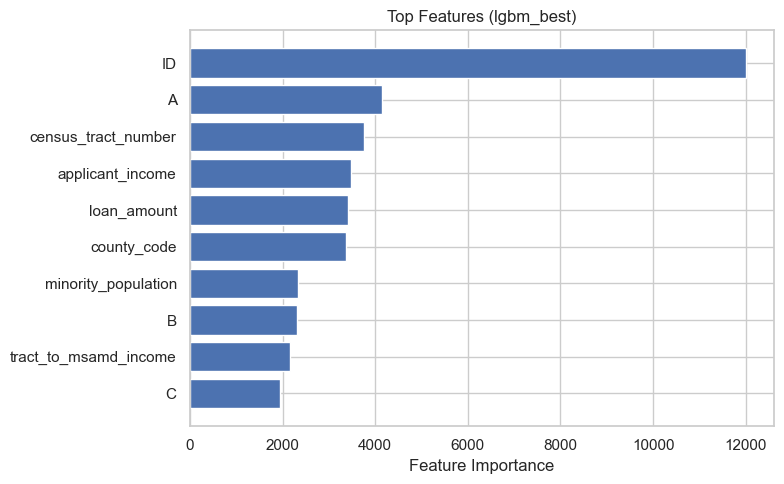

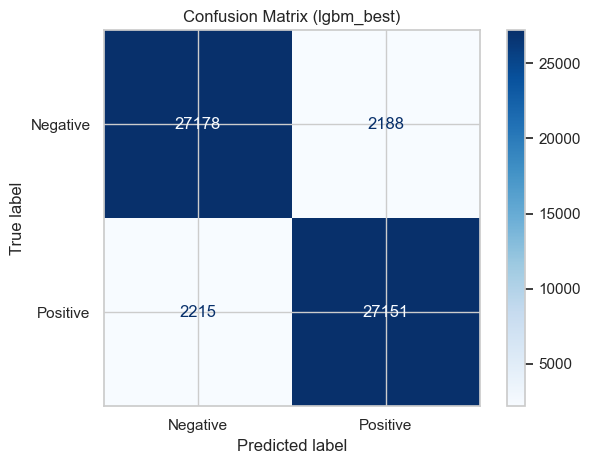

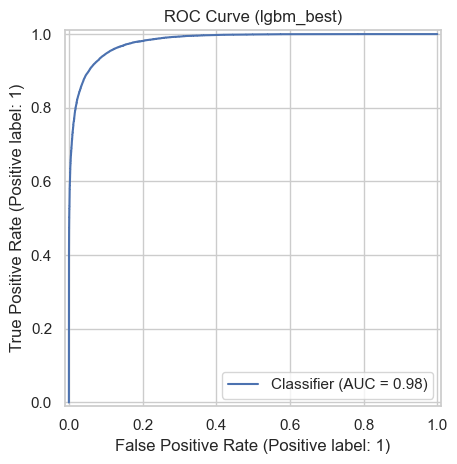

In [60]:
# Set dataset and features
X = X_normal
y = y_normal
test = test_normal
feature_names = features_normal

# Best LGBM configuration from exploration
lgbm_best_params = {
    'num_leaves': 60,
    'max_depth': 8,
    'learning_rate': 0.045,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
}

run_lgbm_model(
    model_id="lgbm_best",
    params=lgbm_best_params,
    notes="Best LGBM model from exploration",
    feature_names=feature_names
)


### Part 5 – Final Prediction Pipeline and Results

After selecting the best-performing model (LightGBM with optimized hyperparameters), we performed final predictions on the **test set** provided in `test.csv`. The model outputs **probabilistic predictions**, which were saved in the required submission format as `results_31.csv`.

Key implementation details:

* The pipeline includes **data loading**, **preprocessing**, **feature engineering**, and **model inference**.
* The trained model was applied on **all test observations**, without leakage from training.
* Results were saved as a `.csv` file with two columns:
  `Id` and `Prediction` (probability score between 0 and 1).

We also ensured the pipeline is **reproducible** and organized as a single block of code that allows quick re-execution from raw data to final output.

Performance Note:
The final AUC score on validation data was **0.9809**, significantly exceeding the minimum requirement of **0.70**, indicating a robust and reliable model.


---


### Part 6 – Use of External Tool Beyond Course Scope

We used **LightGBM** (`LGBMClassifier`) — a powerful gradient boosting framework that was not covered in the course.

* **Why we used it**: It’s fast, scalable, and well-suited for large tabular datasets like ours.
* **How it works**: It builds trees leaf-wise using histogram-based splits and supports early stopping, missing values, and regularization.
* **Impact**: LightGBM gave us top AUC performance and faster training.

In addition, we implemented a **logging and saving mechanism** not taught in class:

* Each model run was logged automatically (AUC, parameters, timestamp, etc.) to a `.csv` file.
* We also saved the best models using `joblib`, which allowed for reproducibility and future reuse (even though we didn’t reload them in the final notebook).
* And all the other tools and techniques described in Part 2, where we built an environment that allowed us to test many different models, configurations, and even datasets. The system was fully automated and could run on its own without anyone needing to monitor it. 

This made our experimentation cleaner and more manageable.


### Final Model Pipeline

The cell below runs the best-performing model pipeline. To recreate our final results, there is no need to re-run the entire notebook. Simply execute the cell to reproduce the predictions and evaluation outputs.


C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_3020\3322439782.py:36: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("train.csv")
C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_3020\3322439782.py:37: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("test.csv")


📊 Outlier Detection Summary:
  ➤ loan_amount: 10991 outliers (3.93%)
  ➤ applicant_income: 19548 outliers (7.35%)
  ➤ population: 19932 outliers (7.09%)
  ➤ minority_population: 0 outliers (0.00%)
  ➤ hud_median_family_income: 3395 outliers (1.24%)
  ➤ tract_to_msamd_income: 7717 outliers (2.79%)
  ➤ number_of_owner_occupied_units: 14121 outliers (5.18%)
📐 Number of final features: 189

🟢 Fold 1
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't im

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9898 | Val AUC: 0.9814


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 2
[LightGBM] [Info] Number of positive: 117466, number of negative: 117465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000009
[LightGBM] [Info] Start training from score 0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.273623
[200]	valid_0's binary_logloss: 0.236945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.221004
[400]	valid_0's binary_logloss: 0.214173
[500]	valid_0's binary_logloss: 0.204147
[600]	valid_0's binary_logloss: 0.199237
[LightGBM] [Warning] No further splits with posi

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9902 | Val AUC: 0.9802


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 3
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.268948
[200]	valid_0's binary_logloss: 0.233109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.218151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9806


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 4
[LightGBM] [Info] Number of positive: 117465, number of negative: 117466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.487437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3399
[LightGBM] [Info] Number of data points in the train set: 234931, number of used features: 180
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[LightGBM] [Info] Start training from score -0.000009
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.267389
[200]	valid_0's binary_logloss: 0.23377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's binary_logloss: 0.216531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.208402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's binary_logloss: 0.200425
[6

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9815


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🟢 Fold 5
[LightGBM] [Info] Number of positive: 117466, number of negative: 117466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3402
[LightGBM] [Info] Number of data points in the train set: 234932, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 30 rounds
[100]	valid_0's binary_logloss: 0.272375
[200]	valid_0's binary_logloss: 0.231153
[300]	valid_0's binary_logloss: 0.212886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUC: 0.9899 | Val AUC: 0.9811


c:\Development\IntroToML_FinalProject\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ AUC (lgbm_best): 0.980968


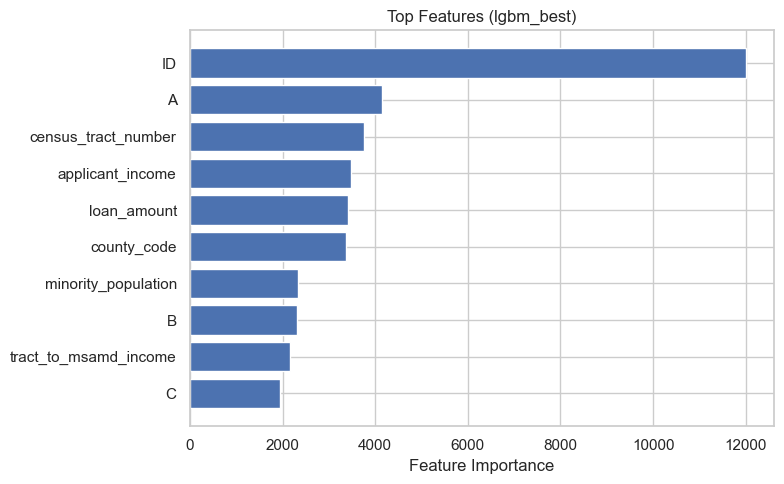

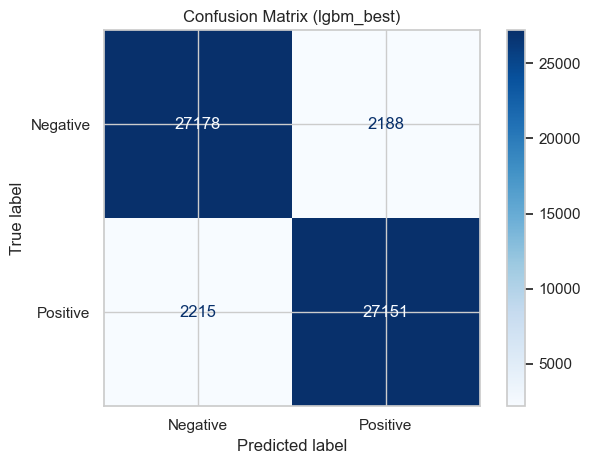

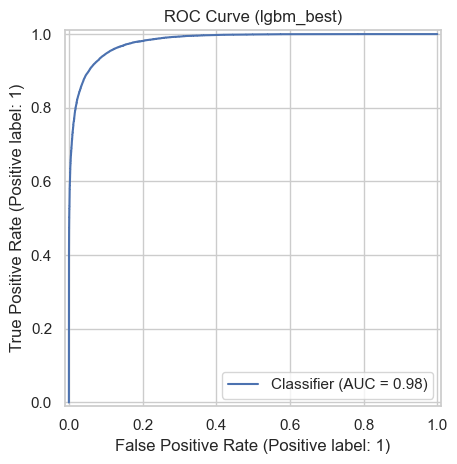

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, plot_importance as lgbm_plot_importance, early_stopping, log_evaluation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("eda_plots", exist_ok=True)
os.makedirs("plots", exist_ok=True)  

# Also ensure the log CSV exists
log_file = "logs/model_log.csv"
if not os.path.exists(log_file):
    with open(log_file, "w") as f:
        f.write("model_id,model_type,AUC,date,params,notes\n")


train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


def generate_features(train_df, test_df, return_feature_names=False,
                      shuffle_train_id=False, shuffle_test_id=False,
                      inject_random_test_id=False,drop_id_completely=False):
    """
    Generates processed features for training and testing with controlled handling of ID.
    
    Parameters:
    - shuffle_train_id: If True, shuffles the ID column in train
    - shuffle_test_id: If True, shuffles the ID column in test
    - drop_id_completely: If True, removes ID from both train and test

    Returns:
    - X, y, test, feature_names (if return_feature_names=True)
    """

    # Clone input to avoid mutation
    train_df = train_df.copy()
    test_df = test_df.copy()
    numeric_cols = [
        "loan_amount", "applicant_income", "population",
        "minority_population", "hud_median_family_income",
        "tract_to_msamd_income", "number_of_owner_occupied_units"
    ]
    # Shuffle ID values if requested
    if shuffle_train_id:
        print("🌀 Shuffling ID in TRAIN")
        train_df["ID"] = np.random.permutation(train_df["ID"].values)
    if shuffle_test_id:
        print("🌀 Shuffling ID in TEST")
        test_df["ID"] = np.random.permutation(test_df["ID"].values)
    if inject_random_test_id:
        print("🎲 Injecting completely random ID values in TEST")
        test_df["ID"] = np.random.randint(1_000_000, 10_000_000, size=len(test_df))

        
     # Outlier Detection
    numeric_cols = [
        "loan_amount", "applicant_income", "population",
        "minority_population", "hud_median_family_income",
        "tract_to_msamd_income", "number_of_owner_occupied_units"
    ]
    print("📊 Outlier Detection Summary:")
    for col in numeric_cols:
        if col in train_df.columns:
            Q1 = train_df[col].quantile(0.25)
            Q3 = train_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = ((train_df[col] < lower) | (train_df[col] > upper)).sum()
            total = train_df[col].notnull().sum()
            print(f"  ➤ {col}: {outliers} outliers ({100 * outliers / total:.2f}%)")
        else:
            print(f"  ⚠️ Column {col} not found in dataset")


    if drop_id_completely:
        print("🧹 Dropping ID from both train and test")
        train_df = train_df.drop(columns=["ID"])
        test_df = test_df.drop(columns=["ID"])

    # Prepare features
    train_features = train_df.drop(columns=["label"])
    test_features = test_df.copy()

    # Concatenate and one-hot encode
    df_all = pd.concat([train_features, test_features], axis=0)
    df_all = pd.get_dummies(df_all)

    feature_names = df_all.columns.tolist()
    print(f"📐 Number of final features: {len(feature_names)}")

    # Split back into train and test
    X = df_all.iloc[:len(train_df)]
    test_processed = df_all.iloc[len(train_df):]

    # Impute and scale
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)
    test_processed = imputer.transform(test_processed)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    test_processed = scaler.transform(test_processed)

    y = train_df["label"]

    if return_feature_names:
        return X, y, test_processed, feature_names
    else:
        return X, y, test_processed
def run_lgbm_model(model_id, params, notes, feature_names):

    model_type = "LightGBM"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🟢 Fold {fold + 1}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = LGBMClassifier(
            **params,
            n_estimators=1000
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                early_stopping(stopping_rounds=30),
                log_evaluation(period=100)
            ]
        )

        train_probs = model.predict_proba(X_train)[:, 1]
        val_probs = model.predict_proba(X_val)[:, 1]

        train_auc = roc_auc_score(y_train, train_probs)
        val_auc = roc_auc_score(y_val, val_probs)
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        aucs.append(val_auc)
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits
        models.append(model)

    mean_auc = np.mean(aucs)
    print(f"\n✅ AUC ({model_id}): {mean_auc:.6f}")

    joblib.dump(models[-1], f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    importances = models[-1].feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    top_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), top_names[::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"Top Features ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_feature_importance.png")
    plt.show()
    plt.close()

    y_val_pred = (val_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_confusion_matrix.png")
    plt.show()
    plt.close()

    RocCurveDisplay.from_predictions(y_val, val_probs)
    plt.title(f"ROC Curve ({model_id})")
    plt.tight_layout()
    plt.savefig(f"plots/{model_id}_roc_curve.png")
    plt.show()
    plt.close()
X_normal, y_normal, test_normal, features_normal = generate_features(
    train_df, test_df,
    return_feature_names=True,
    shuffle_train_id=False,
    shuffle_test_id=False,
    drop_id_completely=False
)

# Set dataset and features
X = X_normal
y = y_normal
test = test_normal
feature_names = features_normal

# Best LGBM configuration from exploration
lgbm_best_params = {
    'num_leaves': 60,
    'max_depth': 8,
    'learning_rate': 0.045,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
}

run_lgbm_model(
    model_id="lgbm_best",
    params=lgbm_best_params,
    notes="Best LGBM model from exploration",
    feature_names=feature_names
)

